# Santa Claus Rally

In [4]:
import datetime as dt
import pandas as pd
import yfinance as yf

import available as avb
import utils as self_utils
from quantified_strategies import strategy_utils as utils

### Rules
1. Buy on the first Friday after the 14th calendar day in December (OPEX Day).
2. Sell on the third trading day of the New Year.

In [19]:
BUY_DAY = 4
BUY_AFTER_CALENDAR_DAY = 14
BUY_IN_MONTH = 12

SELL_ON_NTH_DAY_IN_NEW_YEAR = 5

START = dt.date(2010, 6, 1)
END = dt.date.today()

In [20]:
TICKER = "SPY"

In [21]:
results = self_utils.run(ticker=TICKER, full=True, start=START, end=END, close_on_nth_day_in_new_year=SELL_ON_NTH_DAY_IN_NEW_YEAR)
results

{}
remove api from here


,asset,ret,ret_shifted,active,strat_ret,cum_strat_ret,cum_hodl_ret,enter_flag,trade_number
Date,,,,,,,,,
2010-06-01,83.0106,NaN,0.026040,False,0.0,0.000000,0.026040,False,0
2010-06-02,85.1722,0.026040,0.003444,False,0.0,0.000000,0.029573,False,0
2010-06-03,85.4655,0.003444,-0.035137,False,-0.0,0.000000,-0.006603,False,0
2010-06-04,82.4625,-0.035137,-0.012451,False,-0.0,0.000000,-0.018971,False,0
2010-06-07,81.4358,-0.012451,0.010712,False,0.0,0.000000,-0.008463,False,0
...,...,...,...,...,...,...,...,...,...
2024-02-27,506.9300,0.001858,-0.001322,False,-0.0,0.193643,5.098739,False,14
2024-02-28,506.2600,-0.001322,0.003595,False,0.0,0.193643,5.120664,False,14
2024-02-29,508.0800,0.003595,0.009388,False,0.0,0.193643,5.178127,False,14


In [22]:
df

,enter,exit,strat_ret,cum_strat_ret
Date,,,,
2011-01-01,97.4393,99.6656,0.022848,0.022848
2012-01-01,97.3146,102.4608,0.052882,0.076938
2013-01-01,115.4376,119.0741,0.031502,0.110864
2014-01-01,151.5336,153.1695,0.010796,0.122856
2015-01-01,175.7332,175.2057,-0.003002,0.119486
2016-01-01,173.7150,166.6822,-0.040485,0.074164
2017-01-01,199.6408,200.9006,0.006310,0.080942
2018-01-01,241.0269,247.7284,0.027804,0.110997
2019-01-01,238.6445,236.6287,-0.008447,0.101612


In [8]:
data = utils.get_data(ticker=TICKER, columns="Adj Close").to_frame(name=TICKER)
data = data.loc[(data.index.date >= START) & (data.index.date <= END)]
data.head(5)

{}
remove api from here


,SPY
Date,
2010-01-04,87.1290
2010-01-05,87.3596
2010-01-06,87.4211
2010-01-07,87.7902
2010-01-08,88.0823


In [9]:
data["year_month"] = data.index.map(lambda date: float(dt.datetime.strftime(date, "%Y.%m")))
data["year"] = data.index.year

### Get exit trading day

In [10]:
first_n_days_of_year = data.groupby("year").head(SELL_ON_NTH_DAY_IN_NEW_YEAR)
nth_day_of_year = first_n_days_of_year.groupby("year").tail(1)
nth_day_of_year.index = nth_day_of_year.index.year
nth_day_of_year = nth_day_of_year[TICKER].to_frame(name="exit")
nth_day_of_year.head(5)

,exit
Date,
2010,88.0823
2011,99.6656
2012,102.4608
2013,119.0741
2014,153.1695


### Get enter trading day of each month

In [29]:
first_xday_after_xdate_in_xmonth = data.loc[
    (data.index.month == BUY_IN_MONTH) & (data.index.day >= BUY_AFTER_CALENDAR_DAY) & (data.index.dayofweek >= BUY_DAY)
].groupby("year_month").first()[TICKER]
first_xday_after_xdate_in_xmonth

year_month
2010.12     97.4393
2011.12     97.3146
2012.12    115.4376
2013.12    151.5336
2014.12    175.7332
2015.12    173.7150
2016.12    199.6408
2017.12    241.0269
2018.12    238.6445
2019.12    301.1679
2020.12    353.1365
2021.12    445.7520
2022.12    377.5313
2023.12    469.3300
Name: SPY, dtype: float64

In [31]:
first_xday_after_xdate_in_xmonth = data.loc[
    (data.index.month == BUY_IN_MONTH) & (data.index.day >= BUY_AFTER_CALENDAR_DAY) & (data.index.dayofweek >= BUY_DAY)
].groupby("year_month").first()[TICKER]
first_xday_after_xdate_in_xmonth = first_xday_after_xdate_in_xmonth.to_frame(name="enter")
first_xday_after_xdate_in_xmonth.index = first_xday_after_xdate_in_xmonth.index.astype(int)
first_xday_after_xdate_in_xmonth.index.name = "Date"
first_xday_after_xdate_in_xmonth_shifted = first_xday_after_xdate_in_xmonth.copy()
first_xday_after_xdate_in_xmonth_shifted.index += 1
first_xday_after_xdate_in_xmonth_shifted.tail(5)

,enter
Date,
2020,301.1679
2021,353.1365
2022,445.7520
2023,377.5313
2024,469.3300


### Join Data

In [34]:
df = pd.concat([first_xday_after_xdate_in_xmonth_shifted, nth_day_of_year], axis=1)
df = df.dropna()
df.index = df.index.map(lambda year: dt.datetime.strptime(str(year), "%Y"))
df = df.sort_index()
df.tail(5)

,enter,exit
Date,,
2020-01-01,301.1679,304.6610
2021-01-01,353.1365,364.6916
2022-01-01,445.7520,451.7811
2023-01-01,377.5313,382.0526
2024-01-01,469.3300,474.6000


### Calculate Returns

In [36]:
df["strat_ret"] = df["exit"] / df["enter"] - 1
df["cum_strat_ret"] = utils.get_cumulative_return(returns=df["strat_ret"], total=False)
df

,enter,exit,strat_ret,cum_strat_ret
Date,,,,
2011-01-01,97.4393,99.6656,0.022848,0.022848
2012-01-01,97.3146,102.4608,0.052882,0.076938
2013-01-01,115.4376,119.0741,0.031502,0.110864
2014-01-01,151.5336,153.1695,0.010796,0.122856
2015-01-01,175.7332,175.2057,-0.003002,0.119486
2016-01-01,173.7150,166.6822,-0.040485,0.074164
2017-01-01,199.6408,200.9006,0.006310,0.080942
2018-01-01,241.0269,247.7284,0.027804,0.110997
2019-01-01,238.6445,236.6287,-0.008447,0.101612


### Plot Strategy Returns

In [14]:
import matplotlib.pyplot as plt

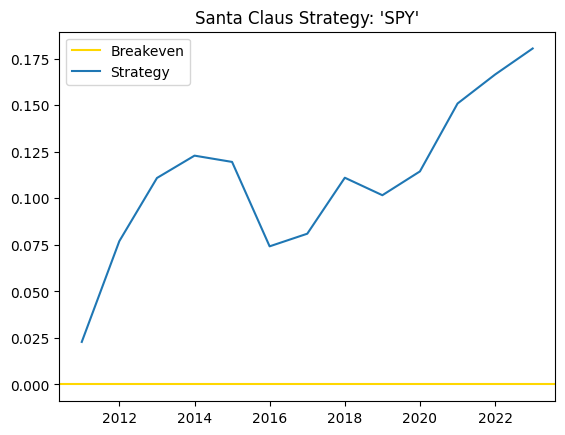

In [15]:
fig, ax = plt.subplots()

ax.axhline(y=0, label="Breakeven", color="gold")

ax.plot(df["cum_strat_ret"], label="Strategy")

plt.title(f"Santa Claus Strategy: {TICKER!r}")
plt.legend(loc="best")
plt.show()

### Describe Strategy

In [16]:
utils.describe(returns=df["strat_ret"], daily=False, asset=TICKER)

Asset                             SPY
Start                      2011-01-01
End                        2023-01-01
Mean Return                  1.30792%
Total Return                   18.04%
Median Return                1.19760%
1st Quartile                 0.16543%
3rd Quartile                 2.96529%
Std Dev Return               2.28536%
CAGR                      128.389 bps
Trade CAGR                        N/A
Ann. CAGR                         N/A
Activity Ratio                100.00%
Number of Trades                  0.0
Average Hold Period        13.00 Days
Daily Sharpe Ratio             0.5723
Ann. Sharpe Ratio              9.0851
Adj. Ann. Sharpe Ratio         9.0851
Daily Sortino Ratio            0.6458
Ann. Sortino Ratio            10.2518
Daily Calmar Ratio             4.1598
Hit Ratio                      76.92%
Profit Factor                   4.27x
MDD                            -4.34%
MDD Start                  2014-01-01
MDD Bottom                 2016-01-01
MDD End     

In [17]:
df

,enter,exit,strat_ret,cum_strat_ret
Date,,,,
2011-01-01,97.4393,99.6656,0.022848,0.022848
2012-01-01,97.3146,102.4608,0.052882,0.076938
2013-01-01,115.4376,119.0741,0.031502,0.110864
2014-01-01,151.5336,153.1695,0.010796,0.122856
2015-01-01,175.7332,175.2057,-0.003002,0.119486
2016-01-01,173.7150,166.6822,-0.040485,0.074164
2017-01-01,199.6408,200.9006,0.006310,0.080942
2018-01-01,241.0269,247.7284,0.027804,0.110997
2019-01-01,238.6445,236.6287,-0.008447,0.101612
